In [38]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 0.) Clean the Apple Data to get a quarterly series of EPS.

In [39]:
#read data APPL_quarterly_financials.csv
#extract the EPS data of it and preprocess it
df = pd.read_csv('AAPL_quarterly_financials.csv',sep=","
              ,index_col= 0  )
df = df.T
df.drop(['ttm'],inplace=True)
df_mt = df[['BasicEPS']]
df_mt.fillna(method="backfill",inplace=True)
df_mt.fillna(0,inplace=True)
df_mt.index = pd.to_datetime(df_mt.index)
df_mt.sort_index(inplace=True,ascending=1)
eps_data = df_mt


/var/folders/_b/4lj1bh0s4473m5xx061k14lc0000gn/T/ipykernel_17862/2059250550.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mt.fillna(method="backfill",inplace=True)
/var/folders/_b/4lj1bh0s4473m5xx061k14lc0000gn/T/ipykernel_17862/2059250550.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mt.fillna(0,inplace=True)
/var/folders/_b/4lj1bh0s4473m5xx061k14lc0000gn/T/ipykernel_17862/2059250550.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

# 1.) Import data. Train, Test, Holdout (80%,15%,5%)
# DELETE

In [40]:
#split the data into train and test
#leave 5% holdout
train_eps,test_eps = train_test_split(eps_data,train_size=0.80,test_size=0.10)


# 3.) Come up with 6 search terms you think could nowcast earnings. (Different than the ones I used) Add in 3 terms that that you think will not Nowcast earnings. Pull in the gtrends data. Clean it to have a quarterly average.

In [41]:
# Create pytrends object
from pytrends.request import TrendReq
pytrends = TrendReq(hl='en-US', tz=360)

# Set up the keywords and the timeframe

#CHANGE THE KEYWORDS LIST FOR BEST NOWCASTING    <--------------------
#--------------------------------------
#--------------------------------------
#--------------------------------------
#keywords = ['Lakers','Warriors','Celtics','Bulls','Knicks','Heat','Spurs','Rockets']
relevant_keywords = ['iphone','iwatch','mac','Siri','Android','Samsung']
irrelevant_keywords = ['turbocharger','otologist','peanut worms']
#combine the relevant and irrelevant keywords
keywords = relevant_keywords + irrelevant_keywords
#the start date and end date of the data could remain the same
start_date = '2004-01-01'
end_date = '2024-01-01'
#--------------------------------------
#--------------------------------------
#--------------------------------------

# Create an empty DataFrame to store the results
df = pd.DataFrame()

# Iterate through keywords and fetch data
for keyword in keywords:
    pytrends.build_payload([keyword], cat=0, timeframe=f'{start_date} {end_date}', geo='', gprop='')
    interest_over_time_df = pytrends.interest_over_time()
    df[keyword] = interest_over_time_df[keyword]
df.fillna(method="backfill",inplace=True)
#change df into quateryly data
df = df.resample("Q").mean()[:"20231230"]


# 2.) Normalize all the X data

In [42]:
#Normalize the data using StandardScaler
from sklearn.preprocessing import MinMaxScaler, StandardScaler
eps_data = eps_data.resample("Q").mean()["2004-01-01":]
display("data scale: ",df.shape,eps_data.shape)
scalar = StandardScaler()

X_std = scalar.fit_transform(df)
display(pd.DataFrame(X_std,index=df.index,columns=df.columns).head())
#y = scalar.fit_transform(eps_data)
y = eps_data.values

'data scale: '

(79, 9)

(79, 1)

,iphone,iwatch,mac,Siri,Android,Samsung,turbocharger,otologist,peanut worms
date,,,,,,,,,
2004-03-31,-1.821981,-1.047574,0.422144,-1.181210,-1.233305,-1.737747,3.230881,-2.072235,2.644384
2004-06-30,-1.821981,-1.047574,0.159072,-1.181210,-1.233305,-1.789578,3.167989,6.932580,2.112139
2004-09-30,-1.821981,-1.047574,0.098364,-1.181210,-1.233305,-1.616809,3.042203,-1.214634,2.484710
2004-12-31,-1.821981,-1.047574,0.482852,-0.949530,-1.233305,-1.478594,2.497133,2.168128,3.495977
2005-03-31,-1.821981,-1.085140,0.826869,-1.052499,-1.233305,-1.530425,2.790632,-0.499966,2.484710


# 4.) Run a Lasso with lambda of .5. Plot a bar chart.

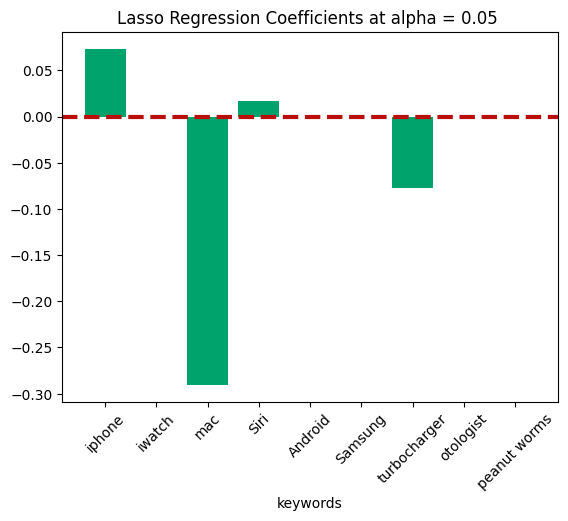

Lasso regression score: 0.05  0.7220954110695137
                  coef
iphone        0.073392
iwatch        0.000000
mac          -0.290366
Siri          0.017055
Android      -0.000000
Samsung       0.000000
turbocharger -0.077801
otologist    -0.000000
peanut worms -0.000000


In [43]:
from sklearn.linear_model import Lasso
#write a function to run the Lasso regression of multivariate
def run_lasso_regression(X, y, alpha):
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    return lasso
alpha = 0.05
reg = run_lasso_regression(X_std,y,alpha)
plt.bar(range(len(reg.coef_)),
    reg.coef_,tick_label=df.columns,color= "#00A36C")
plt.axhline(0, color='#B90E0A', linestyle="--",linewidth=3)
plt.title("Lasso Regression Coefficients at alpha = {} ".format(alpha))
plt.xlabel("keywords")
plt.xticks(rotation=45)
plt.show()
reg.fit(X_std,y)
print("Lasso regression score: {} ".format(alpha),reg.score(X_std,y))
print(pd.DataFrame(reg.coef_,index=df.columns,columns=["coef"]))

# 5.) Do these coefficient magnitudes make sense?

In [44]:
#yes the coefficients magnitudes make sense
#the coefficients of the irrelevant keywords are close to zero
#the coefficients of the relevant keywords are not close to zero,
#with siri and iphone having the highest coefficients
#strongest positive correlation with the EPS

#howeever, the coefficients of mac is unexpectedly negative

# 6.) Run a for loop looking at 10 different Lambdas and plot the coefficient magnitude for each.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1152: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.241e+00, tolerance: 2.062e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

,score
0.00,0.782675
0.01,0.774425
0.05,0.722095
0.10,0.675648
0.20,0.499942
0.50,0.0
0.80,0.0
1.00,0.0
5.00,0.0
10.00,0.0


best alpha:  0.0


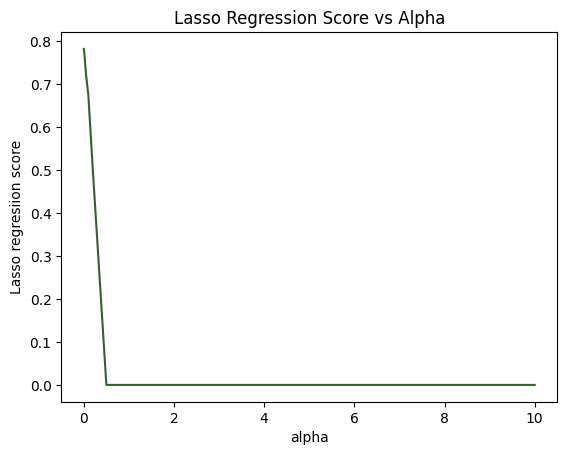

In [47]:
#create a list of alpha values
alphas = [0,0.01,0.05,0.1,0.2,0.5,0.8,1,5,10]
#run the lasso regression for all the alpha values
#and store the scores in a dataframe
scores = pd.DataFrame(columns=["score"],index=alphas)
for alpha in alphas:
    reg = run_lasso_regression(X_std,y,alpha)
    scores.loc[alpha] = reg.score(X_std,y)
plt.plot(scores.index,scores["score"],color="#32612d")
plt.title("Lasso Regression Score vs Alpha")
plt.xlabel("alpha")
plt.ylabel("Lasso regresiion score")
display(scores)
print("best alpha: ",scores[scores["score"] == scores["score"].max()].index.values[0])
#the best alpha is 0, which means no regularization, with OLS being the best result

# 7.) Run a cross validation. What is your ideal lambda?

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1152: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.418e+00, tolerance: 1.570e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

,score1,score2,score3,score4,score5,mean,std
0,-26315.872364,-5.519213,-8.268378,-1.387026,-1.895554,-5266.588507,10524.642228
0.01,-9132.655165,-2.687613,-2.410305,-1.361706,-2.471721,-1828.317302,3652.168960
0.05,-595.029472,-0.826945,-0.483071,-1.087152,-3.771273,-120.239583,237.397813
0.1,-816.775443,-1.350524,-0.294203,-0.588779,-4.774161,-164.756622,326.013328
0.2,-999.921665,-4.174646,-0.032768,-0.010107,-5.731659,-201.974169,398.980148
0.5,-1511.669868,-14.569639,-0.246827,-0.658656,-6.167944,-306.662587,602.525832
0.8,-1511.669868,-14.569639,-0.246827,-0.658656,-6.167944,-306.662587,602.525832
1,-1511.669868,-14.569639,-0.246827,-0.658656,-6.167944,-306.662587,602.525832
5,-1511.669868,-14.569639,-0.246827,-0.658656,-6.167944,-306.662587,602.525832
10,-1511.669868,-14.569639,-0.246827,-0.658656,-6.167944,-306.662587,602.525832


best alpha:  0.05  with cross validation score:  -120.23958262019039


Text(0.5, 1.0, 'Lasso Regression Cross Validation Scores')

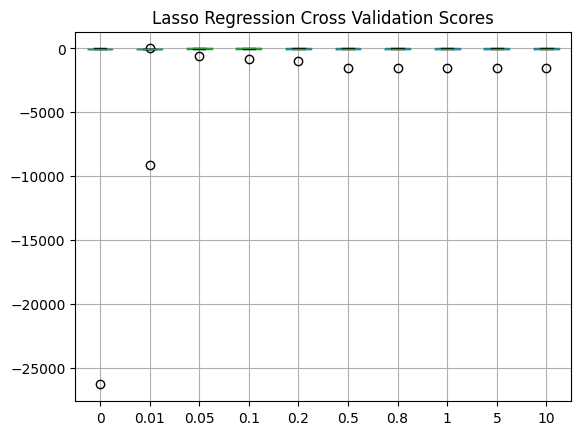

In [46]:
#using cross validation to find the best alpha
from sklearn.model_selection import cross_val_score

n = 5
#run the lasso regression for all the alpha values
#and store the scores in a dataframe
scores_cross_validation = pd.DataFrame(columns=['score{}'.format(i) for i in range(1,n+1)])

for alpha in alphas:
   lasso = Lasso(alpha=alpha)
   fit = cross_val_score(lasso, X_std, y, cv=n)
   scores_cross_validation.loc[str(alpha)] = fit
scores_cross_validation["mean"] = scores_cross_validation.mean(axis=1)
scores_cross_validation['std'] = scores_cross_validation.std(axis=1)
display(scores_cross_validation)
#the higher cross validation score, the better
#the lower std, the better


#return the alpha with the highest cross validation score
best_alpha = scores_cross_validation["mean"].idxmax()
print("best alpha: ",best_alpha," with cross validation score: ",scores_cross_validation.loc[best_alpha,"mean"])
scores_cross_validation.drop(["mean","std"],axis=1,inplace=True)
scores_cross_validation.T.boxplot().set_title("Lasso Regression Cross Validation Scores")
#the ideal alpha is 0.01, with comparatively high cross validation score
#and low std